# FINAL PROJECT


Ryan Timbrook (RTIMBROO)<br>
DATE: 12/3/2019<br>
Topic: <br>


## 1. Objective
_____________________________________________________________________________________________
Task 1:

-	Build a unigram MNB model and a unigram SVMs model.
-	Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
-	You can change other parameters to your preference. Report your choice and explain why. 
-	Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
-	Submit your revised script along with your report.

Task 2:

Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. 

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

Task 3:

Revise the script to build the best model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.


___________________________________________________________________________________________
## FOR RUNNING IN GOOGLE COLAB ONLY ##

In [1]:
# toggle for working with colab
isColab = False

In [2]:
#*ONLY RUN WHEN WORKING ON COLAB*
#===================================================
# mount google drive for working in colab

#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)

# working within colab, set base working directory
#base_dir = "./gdrive/My Drive/IST707_PRJ_Realestate/buy_rent_sell/"

# validate directory mapping
#ls f'{base_dir}'

# upload custome python files
#from google.colab import files
#uploaded_files = files.upload()

# print files uploaded
#for f in uploaded_files.keys():
#  print(f'file name: {f}')

#isColab = True

______________________________________________________________________________________________
### Coding Environment Setup
Import packages

In [3]:
# import packages for analysis and modeling
# import packages for analysis and modeling
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
import matplotlib.pyplot as plt #2D plotting
%matplotlib inline
import seaborn as sns #
import os
import io
from os import path
import json
import re
from itertools import product
from datetime import date
from datetime import time
from datetime import datetime

# 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, make_scorer, classification_report, recall_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import itemfreq

import warnings
from timeit import default_timer               # performance processing time
import logging                                 # logging framework
# get loggers
warnings.filterwarnings('ignore')

In [4]:
# custome python packages
import rtimbroo_utils_hw7 as br             # custome python helper functions

In [5]:
# get current date
now = datetime.utcnow().isoformat()
collection_date = re.findall('^[0-9]{4}-[0-9]{2}-[0-9]{2}',now)
collection_date

['2019-12-08']

In [6]:
# set global properties
notebook_file_name = 'classification_modeling_mnb_svm'
report_file_name = 'classification_modeling_mnb_svm'
app_name = 'classification_modeling_mnb_svm'
log_level = 10 # 10-DEBUG, 20-INFO, 30-WARNING, 40-ERROR, 50-CRITICAL

# setup working directory structure
# set global properties
if not isColab:
    dataDir = './data'
    outputDir = './output'
    configDir = './config'
    logOutDir = './logs'
    imageDir = './images'
    modelDir = './models'
    corpusDir = './corpus'
else:
    # working within colab
    dataDir = f'{base_dir}data'
    outputDir = f'{base_dir}output'
    configDir = f'{base_dir}config'
    logOutDir = f'{base_dir}logs'
    imageDir = f'{base_dir}images'
    modelDir = f'{base_dir}models'
    corpusDir = f'{base_dir}corpus'

In [7]:
# create base output directories if they don't exist
if not os.path.exists(outputDir): os.mkdir(outputDir)
if not os.path.exists(logOutDir): os.mkdir(logOutDir)
if not os.path.exists(imageDir): os.mkdir(imageDir)
if not os.path.exists(modelDir): os.mkdir(modelDir)
if not os.path.exists(corpusDir): os.mkdir(corpusDir)

In [8]:
# get a logger for troubleshooting / data exploration
logger = br.getFileLogger(logOutDir+'/',app_name+'_'+collection_date[0],level=log_level)

#### Create Model with CV
Python Package: [SciKit-Learn model_selection cross_validate](https://scikit-learn.org/stable/modules/cross_validation.html)   
See also [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more details.  

A risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.  

Cross-Validate at 10 folds...

In [9]:
# summary report containers
model_types = []
categories = []
vectorizers = []
ngrams = []
exp_model_names = []
dataset_versions = []
cross_folds = []
prediction_accuracys = []
total_prediction_points = []
test_recall_score_avgs = []
test_precision_score_avgs = []
train_recall_score_avgs = []
train_precision_score_avgs = []
total_build_times = []
total_predict_time = []
confusion_matrixs = []

In [10]:
def build_test_validate_models(vectorizer,mtype,model,m_name,X,y,reportPath,outputDir,cv=10,test_size=0.3,n_classes=2):
    model_names = []
    labels = [l for l in range(0,n_classes)]
    
    #------------------SUMMARY REPORT DATA ----------------------------#
    cross_folds.append(cv) # summary report
    exp_model_names.append(m_name) # summary report
    
    # get model type
    if mtype == 'mnb':
        model_types.append('Multinomial_Naive_Bayes')
    elif mtype == 'svm':
        model_types.append('LinearSVM')
    else:
        model_types.append('UNKNOWN')
    
    # get category
    category = ''
    if 'task1' in m_name:
        categories.append('task_1')
        category = 'task_1'
    elif 'task2' in m_name:
        categories.append('task_2')
        category = 'task_2'
    elif 'task3' in m_name:
        categories.append('task_3')
        category = 'task_3'
    elif 'task4' in m_name:
        categories.append('task_4')
        category = 'task_4'
    else:
        categories.append('UNKNOWN')
    
    # get vectorizer type
    v_type = ''
    if 'cnt' in m_name:
        vectorizers.append('count')
        v_type = 'count'
    elif 'tfidf' in m_name:
        vectorizers.append('tfidf')
        v_type = 'tfidf'
    else:
        vectorizers.append('UNKNOW')
    
    # get ngram type
    ngram_type = ''
    if 'unigram' in m_name:
        ngrams.append('unigram')
        ngram_type = 'unigram'
    elif 'bigram' in m_name:
        ngrams.append('bigram')
        ngram_type = 'bigram'
    else:
        ngrams.append('UNKNOWN')
    
    # get dataset version
    dataset_versions.append(f'v{m_name[-1:]}')
    d_version=m_name[-1:]
    
    
    #------------------------------------------------------------------------#
    
    
    # create training test splits
    # hold out part of the available data as a test set X_test, y_test
    with open(f'{reportPath}', 'a') as f:
        logger.info(f'Model Name:             {m_name}')
        f.write('{0:-<40} {1}\n'.format('Model Name:',m_name))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

        # plot training validating label split
        br.plot_train_test_label_split(y_train, y_test, n_classes)
        
        # one hot encoding for dataset labels
        lbe = LabelEncoder()
        y_train = lbe.fit_transform(y_train)
        y_test = lbe.fit_transform(y_test)
        
        
        #-------------------Perform Vectorization of dataset----------------------------#
        train_vec = br.train_vector(logger, vectorizer, X_train, category=category, v_type=v_type, version=d_version)
        X_train_vec = train_vec[1]
        logger.info(f'X_train_vec.shape: {X_train_vec.shape}')
        
        # use the vocabulary constructed from the training data to vectorize the test data. 
        # Therefore, use "transform" only, not "fit_transform", 
        # otherwise "fit" would generate a new vocabulary from the test data
        X_test_vec = vectorizer.transform(X_test)
        logger.info(f'X_test_vec.shape: {X_test_vec.shape}')
        
        #-------------------Build Cross Validate Model----------------------------#
        
        scoring = ['precision_macro', 'recall_macro']
        t = 0.0
        with br.elapsed_timer() as elapsed:
            model_scores = cross_validate(model, X_train_vec, y_train, scoring=scoring, cv=cv, 
                                        return_train_score=True, return_estimator=True) 
            t = elapsed()
            logger.info(f' Build Time: [{t}]')
            f.write('{0:-<40} {1}\n'.format('Build Time: ',[t]))
            total_build_times.append(round(t, 4))
        
        #--------------------------------------------------------------------------#
        
        logger.debug(f'Fit Time:               {model_scores["fit_time"]} | Fit Time Avg: {np.mean(model_scores["fit_time"])}')
        logger.debug(f'Score Time:             {model_scores["score_time"]} | Score Time Avg: {np.mean(model_scores["score_time"])}')
        logger.debug(f'Test Recall Scores:     {model_scores["test_recall_macro"]} | Test Recall Avg: {np.mean(model_scores["test_recall_macro"])}')
        logger.debug(f'Test Precision Scores:  {model_scores["test_precision_macro"]} | Test Precision Avg: {np.mean(model_scores["test_precision_macro"])}')
        logger.debug(f'Train Recall Scores:    {model_scores["train_recall_macro"]} | Train Recall Avg: {np.mean(model_scores["train_recall_macro"])}')
        logger.debug(f'Train Precision Scores: {model_scores["train_precision_macro"]} | Train Precision Avg: {np.mean(model_scores["train_precision_macro"])}')
                    
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Fit Time:',[model_scores["fit_time"]],[np.mean(model_scores["fit_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Score Time:',[model_scores["score_time"]],[np.mean(model_scores["score_time"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Recall Scores:',[model_scores["test_recall_macro"]],[np.mean(model_scores["test_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Test Precision Scores:',[model_scores["test_precision_macro"]],[np.mean(model_scores["test_precision_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Recall Scores:',[model_scores["train_recall_macro"]],[np.mean(model_scores["train_recall_macro"])]))
        f.write('{0:-<40} {1} | Avg:[{2}]\n'.format('Train Precision Scores:',[model_scores["train_precision_macro"]],[np.mean(model_scores["train_precision_macro"])]))
        
        # update report value
        test_recall_score_avgs.append(round(np.mean(model_scores["test_recall_macro"]),4)) # summary report 
        test_precision_score_avgs.append(round(np.mean(model_scores["test_precision_macro"]),4)) # summary report 
        train_recall_score_avgs.append(round(np.mean(model_scores["train_recall_macro"]),4)) # summary report 
        train_precision_score_avgs.append(round(np.mean(model_scores["train_precision_macro"]),4))  # summary report            
                     
                     
        #---------------------BEST FIT ESTIMATOR-----------------------------------#
        # best fit estimator
        bestFit = model_scores["test_precision_macro"].argmax()
        model_scores_est = model_scores['estimator'][bestFit]
        logger.info(f'bestFit model: test_precision_macro.argmax(): {bestFit}')
        
                     
        #---------------------PRINT Top 10 Positive Words-----------------------------------#
        # Top 10 positive
        logger.info(f'Top and Bottom 10 POSITIVE Words Learned:')
        top_bottom_most_pos = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=2)           
        f.write('\n Top and Bottome 10 of Most POSITIVE Learned Words ')
        f.write('\n')
        for p in top_bottom_most_pos:
            f.write(f'{p}\n')
        f.write('\n')           
                     
        #---------------------PRINT Top 10 Negative Words-----------------------------------#
        # Top 10 negative
        logger.info(f'Top and Bottom 10 NEGATIVE Words Learned:')
        top_bottom_most_neg = br.show_most_and_least_informative_features(logger, vectorizer, model_scores_est, class_idx=0)
        f.write('\n Top and Bottome 10 of Most NEGATIVE Learned Words ')
        f.write('\n')
        for n in top_bottom_most_neg:
            f.write(f'{n}\n')
        f.write('\n')           
                     
        # predict on unseen data
        t = 0.0
        logger.info(f'Predict: X_test_vec.shape:{X_test_vec.shape}')
        with br.elapsed_timer() as elapsed:
            model_pred = model_scores_est.predict(X_test_vec)
            
            t = elapsed()
            logger.info(f'{m_name} with CV Predict Time: [{t}]')
            f.write('\n{0:-<40} {1}\n'.format('Predict Time:',[t]))
            
            total_predict_time.append(round(t,4)) # summary report
        #---------------------------------------------------------------------------#
        
        #---------------------EVALUATE MODEL----------------------------------------#
        misLabeled = (y_test != model_pred).sum()/X_test.shape[0]
        nbCVAccuractelyLabeled = 1-misLabeled

        logger.debug(f'Total Number of points: [{X_test.shape[0]}]  Mislabeled Points: [{(y_test != model_pred).sum()}]')
        logger.debug(f'Percent Mislabeled: [{((y_test != model_pred).sum()/X_test.shape[0])}]')
        logger.debug(f'Percent Accurately Labeled: [{nbCVAccuractelyLabeled}]')
        f.write('\n')
        f.write('{0:-<40} {1} | {2}\n'.format('Total Number of points | Misslabeled Points:',[X_test.shape[0]],[(y_test != model_pred).sum()]))
        f.write('{0:-<40} {1}\n'.format('Percent Mislabeled:',[((y_test != model_pred).sum()/X_test.shape[0])]))
        f.write('{0:-<40} {1}\n'.format('Percent Accurately Labeled:',[nbCVAccuractelyLabeled]))
        
        prediction_accuracys.append(round(nbCVAccuractelyLabeled*100,2)) # summary report
        total_prediction_points.append(X_test.shape[0]) # summary report            
        
        # confusion matrix evaluation
        cm = confusion_matrix(y_test,model_pred, labels=labels)
        logger.info(f'{cm}')
        f.write(f'Confusion Matrix: \n{cm}\n')
        f.write(f'\n')
        
        confusion_matrixs.append(str(cm)) # summary report
        br.plot_confusion_matrix(cm,classes=labels)
        
        logger.info(f'y_test head: {y_test[:10]}')
        logger.info(f'model_pred head: {model_pred[:10]}')
    
        # classification report
        target_names = [class_to_description[l] for l in labels]
        cr = classification_report(y_test, model_pred, target_names=target_names)
        logger.info(f'{cr}')
        f.write(f'Classification Report: \n{cr}\n')
        f.write(f'\n')
                     
        #             
        
        #---------------------------------------------------------------------------#
                    
        #--------------------Model Results-------------------------------------------#
        result_df = pd.DataFrame()
        result_df['True_Label'] = y_test
        result_df['Predicted_Label'] = model_pred
        result_df['Phrase'] = X_test[1]
                     
        return result_df
        
        # create a merged dataframe of the true, predicted labels along with the word frequency vector for observation
        #fname = feature_vec_file.split('.')
        #fversion = fname[0][-1:]
                     
        #path = f'{outputDir}/v{fversion}/{feature_vec_file}'
        #save_as = f'{outputDir}/{mtype}_{m_name}_predicted_results.csv'

        #predicted_results_wf = br.evaluate_predicted_result(logger, f'{path}',result_df)
        #logger.info(predicted_results_wf.head(10))

        #predicted_results_wf.to_csv(save_as,index=False)

## 2. OBTAIN the data   
________________________________________________________________________________________________


The dataset is comprised of 

* **train.tsv:** 

**The sentiment labels are:**<br>

* 0 - negative
* 1 - neutral
* 2 - positive


In [11]:
n_classes = 3
class_to_label = {0:'0',1:'1',2:'2'}
label_to_class = {'0':0, '1':1, '2':2,}
label_to_description = {'0':'negative', '1':'neutral', '2':'positive'}
class_to_description = {0:'negative', 1:'neutral', 2:'positive'}

In [12]:
# datasets file names to load
#train = pd.read_csv(f'{dataDir}/train/train_tweets_combined_master_clean.csv', encoding='latin')

# best data set of NFL labeled data to be used for modeling
#train = pd.read_csv(f'{dataDir}/train/sentiment_labeled_train_nfl_clean.csv', encoding='latin')
train = pd.read_csv(f'{dataDir}/nfl_master_sent_merged_timeseries.csv', encoding='latin')

# data set that has airline and gop tweet data - poor modeling performance 
#train = pd.read_csv(f'{dataDir}/train/train_tweets_master.csv', encoding='latin')



logger.info(f'train shape: {train.shape}')
logger.info(f'train size: {train.size}')
logger.info(f'train len: {len(train)}')
logger.info(f'train info: {train.info()}')

train shape: (9928, 17)
train size: 168776
train len: 9928
train info: None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9928 entries, 0 to 9927
Data columns (total 17 columns):
id                  9928 non-null int64
created_at          9928 non-null object
date                9928 non-null object
time                9928 non-null object
user                9928 non-null object
favorite_count      9928 non-null float64
year                9928 non-null int64
month               9928 non-null int64
day_of_month        9928 non-null int64
day_of_week         9928 non-null int64
nfl_type            9928 non-null object
nfl_schedule_wk     9928 non-null int64
text                9870 non-null object
text_clean          9708 non-null object
sentiment_scores    9928 non-null object
sentiment           9928 non-null object
sentiment_class     9928 non-null int64
dtypes: float64(1), int64(7), object(9)
memory usage: 1.3+ MB


In [13]:
train.head()

,id,created_at,date,time,user,favorite_count,year,month,day_of_month,day_of_week,nfl_type,nfl_schedule_wk,text,text_clean,sentiment_scores,sentiment,sentiment_class
0,1200925546487504897,Sat Nov 30 23:52:17 +0000 2019,2019-11-30,23:52:17,miamidolphin12,1398.0,2019,11,30,5,team,13,RT SEVENTEEN!,seventeen,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
1,1200925257407827968,Sat Nov 30 23:51:08 +0000 2019,2019-11-30,23:51:08,JT_Evans97,28503.0,2019,11,30,5,player,13,You mean the same fan experts who could see La...,mean fan experts could see would great,"{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'comp...",positive,2
2,1200924548700495872,Sat Nov 30 23:48:19 +0000 2019,2019-11-30,23:48:19,MigiziLaFern,161.0,2019,11,30,5,player,13,Deshaun Watson or Sam Darnold? WhoShouldIStart,whoshouldistart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
3,1200924401002303498,Sat Nov 30 23:47:43 +0000 2019,2019-11-30,23:47:43,DelindaTierney,3148.0,2019,11,30,5,team,13,"Since 2012, Tom Brady has won 7 straight games...",since straight games ppg ypg ypa intÃÂ¢ÃÂÃ...,"{'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'comp...",positive,2
4,1200922963375280129,Sat Nov 30 23:42:01 +0000 2019,2019-11-30,23:42:01,TifdanyBrooks,10198.0,2019,11,30,5,player,13,RT Top 5 current NFL quarterbacks 1. Tom Bra...,top current quarterbacks russel watsonÃÂ¢ÃÂ...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",positive,2


In [14]:
#train['sentiment_class'] = convert_sent_labels(train,'sentiment')

In [15]:
train.head()

,id,created_at,date,time,user,favorite_count,year,month,day_of_month,day_of_week,nfl_type,nfl_schedule_wk,text,text_clean,sentiment_scores,sentiment,sentiment_class
0,1200925546487504897,Sat Nov 30 23:52:17 +0000 2019,2019-11-30,23:52:17,miamidolphin12,1398.0,2019,11,30,5,team,13,RT SEVENTEEN!,seventeen,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
1,1200925257407827968,Sat Nov 30 23:51:08 +0000 2019,2019-11-30,23:51:08,JT_Evans97,28503.0,2019,11,30,5,player,13,You mean the same fan experts who could see La...,mean fan experts could see would great,"{'neg': 0.0, 'neu': 0.439, 'pos': 0.561, 'comp...",positive,2
2,1200924548700495872,Sat Nov 30 23:48:19 +0000 2019,2019-11-30,23:48:19,MigiziLaFern,161.0,2019,11,30,5,player,13,Deshaun Watson or Sam Darnold? WhoShouldIStart,whoshouldistart,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1
3,1200924401002303498,Sat Nov 30 23:47:43 +0000 2019,2019-11-30,23:47:43,DelindaTierney,3148.0,2019,11,30,5,team,13,"Since 2012, Tom Brady has won 7 straight games...",since straight games ppg ypg ypa intÃÂ¢ÃÂÃ...,"{'neg': 0.0, 'neu': 0.808, 'pos': 0.192, 'comp...",positive,2
4,1200922963375280129,Sat Nov 30 23:42:01 +0000 2019,2019-11-30,23:42:01,TifdanyBrooks,10198.0,2019,11,30,5,player,13,RT Top 5 current NFL quarterbacks 1. Tom Bra...,top current quarterbacks russel watsonÃÂ¢ÃÂ...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",positive,2


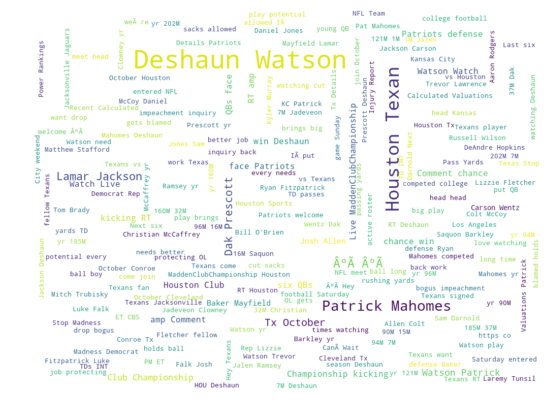

In [16]:
# wordcloud of complete training set - uncleaned text
br.wordcloud_draw(train['text'], color='white',max_words=200)

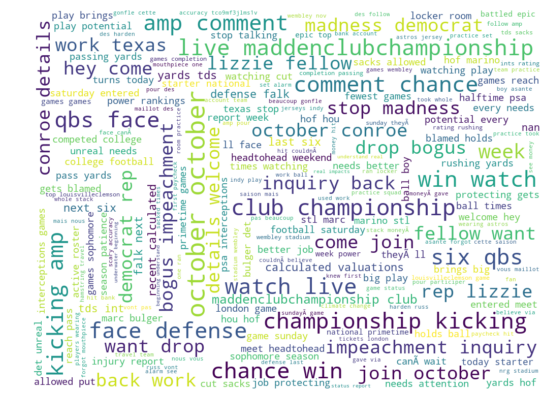

In [17]:
# wordcloud of complete training set - cleaned text
br.wordcloud_draw(train['text_clean'], color='white',max_words=200)

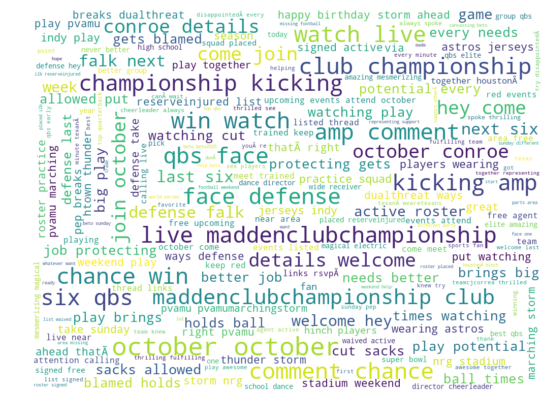

In [18]:
# draw positive word cloud
pos_text = train[train['sentiment']=='positive'].text_clean
# wordcloud of complete training set
br.wordcloud_draw(pos_text, color='white',max_words=200)

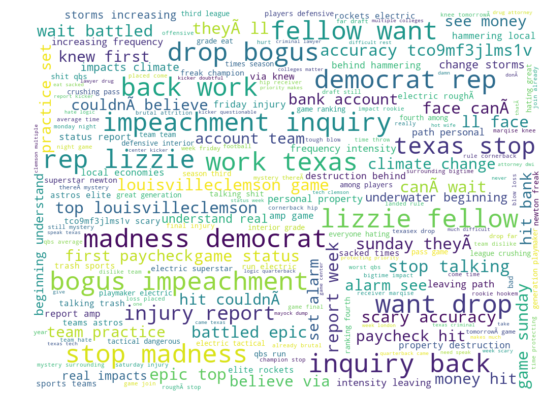

In [19]:
# draw positive word cloud
neg_text = train[train['sentiment']=='negative'].text_clean
# wordcloud of complete training set
br.wordcloud_draw(neg_text, color='white',max_words=200)

In [20]:
# draw positive word cloud
#neg_player_text = train[train['sentiment']=='negative' & train['nfl_type'] == 'player'].text
# wordcloud of complete training set
#br.wordcloud_draw(neg_player_text, color='white',max_words=200)

In [21]:
# this block is just to filter out non-utf8 text from the data set. it was causing the Vectorizer classes to fail
train_dict = train[['id','text_clean','sentiment_class','nfl_type']]
text_tokens = []
text_ids = []
text_classes = []
text_nfl_types = []

for index, row in train_dict.iterrows():
    try:
        tokens = word_tokenize(str(row['text_clean']))
        
        text_tokens.append(tokens)
        text_ids.append(row['id'])
        text_classes.append(row['sentiment_class'])
        text_nfl_types.append(row['nfl_type'])
    except BaseException as be:
        logger.warning(f'****WARNING***: Caught Exception Tokenizing text: {be}')



In [22]:
text_tokens[:10]

[['seventeen'],
 ['mean', 'fan', 'experts', 'could', 'see', 'would', 'great'],
 ['whoshouldistart'],
 ['since',
  'straight',
  'games',
  'ppg',
  'ypg',
  'ypa',
  'intÃ\x83Â¢Ã\x82Â\x80Ã\x82Â\x99s',
  'games',
  'yards'],
 ['top',
  'current',
  'quarterbacks',
  'russel',
  'watsonÃ\x83Â¢Ã\x82Â\x80Ã\x82Â¦'],
 ['picks', 'predictions', 'topbuzz'],
 ['team',
  'team',
  'like',
  'team',
  'dislike',
  'team',
  'hate',
  'nflÃ\x83Â¢Ã\x82Â\x80Ã\x82Â¦'],
 ['nan'],
 ['leaders', 'total', 'qbr', 'week'],
 ['top', 'right', 'unbiased', 'thoughts']]

In [23]:
train_clean_df = pd.DataFrame()
text = []
for doc in text_tokens:
    text.append(' '.join(doc))


train_clean_df['id'] = text_ids
train_clean_df['text'] = text
train_clean_df['sentiment_class'] = text_classes
train_clean_df['nfl_type'] = text_nfl_types
train_clean_df.shape

(9928, 4)

In [24]:
train_clean_df['text'][:5]

0                                            seventeen
1               mean fan experts could see would great
2                                      whoshouldistart
3    since straight games ppg ypg ypa intÃÂ¢ÃÂÃ...
4    top current quarterbacks russel watsonÃÂ¢ÃÂ...
Name: text, dtype: object

In [25]:
#
X_players = train_clean_df[train_clean_df['nfl_type']=='player']['text'].values
y_players = train_clean_df[train_clean_df['nfl_type']=='player']['sentiment_class'].values

X_teams = train_clean_df[train_clean_df['nfl_type']=='teams']['text'].values
y_teams = train_clean_df[train_clean_df['nfl_type']=='teams']['sentiment_class'].values

X_coaches = train_clean_df[train_clean_df['nfl_type']=='coaches'].values
y_coaches = train_clean_df[train_clean_df['nfl_type']=='coaches']['sentiment_class'].values

#X = X_players
#y = y_players

X = train_clean_df['text'].values
y = train_clean_df['sentiment_class'].values.astype('int32',copy=False)

#X = train['text_clean'].values
#y = train['sentiment_class'].values.astype('int32',copy=False)
logger.info(f'X shape: {X.shape}')
logger.info(f'y shape: {y.shape}')
logger.info(f'y unique lables: {train.sentiment_class.unique()}')

X shape: (9928,)
y shape: (9928,)
y unique lables: [1 2 0]


## TASK 1:
________________________________________________________________________________________________
Output confusion matrix, precision and recall values for the Sentiment training data.

* Build a unigram MNB model and a unigram SVMs model.
* Print the top 10 indicative words for the most positive category and the most negative category from the MNB and SVMs models respectively. 
* You can change other parameters to your preference. Report your choice and explain why. 
* Report the confusion matrix, precisions, and recalls. Explain whether your models performed equally well on all categories, or some categories turn out to be easier or more difficult for MNB or SVMs. 
* Submit your revised script along with your report.

### Split train/test data for hold-out test
* 60/40 split ratio
* plot training/test label balance
* perform one-hot encoding on dataset labels
* initalize unigram CountVectorizer
* train vector on X_train content

#### Multinomial Naive Bayes Classification (MNB)
Python package scikit-learn v0.21.3 [sklearn.naive_bayes.MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.htm)


Naive Bayes classifier for multinomial models

The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes).

In [26]:
token_pattern = r'[a-zA-Z\-][a-zA-Z\-]{2,}'


In [27]:
# Initialize a unigram vector object
t1_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,max_df=0.95,input='content',stop_words='english', token_pattern=token_pattern)
t1_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,max_df=0.95,input='content',stop_words='english', token_pattern=token_pattern)

In [28]:
# Input parameter configurations
reportPath_task1 = f'{outputDir}/task1_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task1_mnb_cnt_vec_unigram_v1


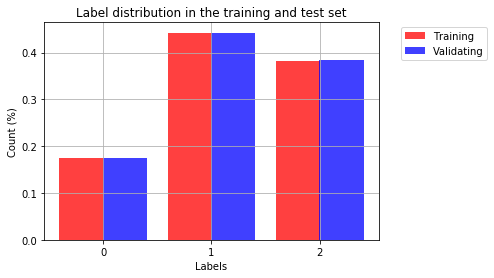

Vectorizer[count], category[task_1], version[1] --> transformed shape: (5956, 2837)
Vectorizer[count], category[task_1], version[1] --> transformed size: 41147
Vectorizer[count], category[task_1], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[1] --> vocabulary size: 2837
Vector Top 20 Head:
         feature  feature_index
1209       zone           2836
2525    youtube           2835
600       youth           2834
1859       ylem           2833
1888  yesterday           2832
772         yes           2831
1382     yellow           2830
659       years           2829
2270   yearbook           2828
569        year           2827
2570       yeah           2826
2814        yea           2825
2324        yds           2824
174       yards           2823
711      yardas           2822
1819       yall           2821
1137       yale           2820
44        yahoo           2819
2009        xxl           2818
2622       xxii  

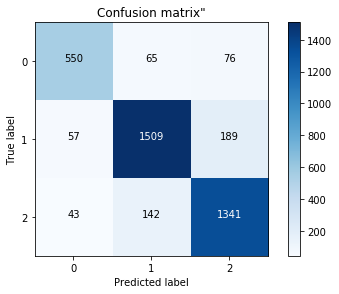

y_test head: [2 0 2 0 1 2 2 1 1 2]
model_pred head: [2 2 2 0 1 2 2 1 2 2]
              precision    recall  f1-score   support

    negative       0.85      0.80      0.82       691
     neutral       0.88      0.86      0.87      1755
    positive       0.83      0.88      0.86      1526

   micro avg       0.86      0.86      0.86      3972
   macro avg       0.85      0.84      0.85      3972
weighted avg       0.86      0.86      0.86      3972



In [29]:
# instantiate niave bayes models
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task1_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_test_pred_results = build_test_validate_models(t1_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

##### Print the top 10 indicative words for the most positive category and the most negative category
Interpret the trained model

##### Linear Support Vector Classification (LinearSVC)
Python package scikit-learn v0.21.3 [sklearn.svm.LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)

Linear Support Vector Classification.

Similar to SVC with parameter kernel=’linear’, but implemented in terms of liblinear rather than libsvm, so it has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

This class supports both dense and sparse input and the multiclass support is handled according to a one-vs-the-rest scheme.

Read more in the [User Guide](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

**Interpreting LinearSVC models**
* LinearSVC uses a one-vs-all strategy to extend the binary SVM classifier to multi-class problems
* For the Kaggle sentiment classification problem, there are five categories 0,1,2,3,4 with 0 as very negative and 4 very positive
* LinearSVC builds five binary classifier, "very negative vs. others", "negative vs. others", "neutral vs. others", "positive vs. others", "very positive vs. others", and then pick the most confident prediction as the final prediction.
* Linear SVC also ranks all features based on their contribution to distinguish the two concepts in each binary classifier

Model Name:             task1_svm_cnt_vec_unigram_v1


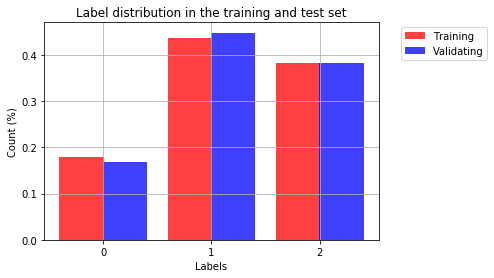

Vectorizer[count], category[task_1], version[1] --> transformed shape: (5956, 2801)
Vectorizer[count], category[task_1], version[1] --> transformed size: 41076
Vectorizer[count], category[task_1], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_1], version[1] --> vocabulary size: 2801
Vector Top 20 Head:
         feature  feature_index
739        zone           2800
2212    youtube           2799
869       youth           2798
2170    younger           2797
2764       ylem           2796
1331  yesterday           2795
640         yes           2794
1033     yellow           2793
248       years           2792
689        year           2791
1086       yeah           2790
1974        yea           2789
562         yds           2788
110       yards           2787
259      yardas           2786
2486       yarb           2785
1554    yankees           2784
2348       yall           2783
317       yahoo           2782
468     xxlarge  

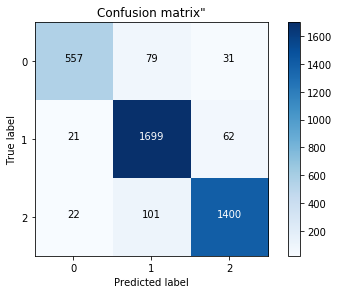

y_test head: [2 2 2 0 0 2 2 0 2 1]
model_pred head: [2 2 2 0 0 2 2 2 2 1]
              precision    recall  f1-score   support

    negative       0.93      0.84      0.88       667
     neutral       0.90      0.95      0.93      1782
    positive       0.94      0.92      0.93      1523

   micro avg       0.92      0.92      0.92      3972
   macro avg       0.92      0.90      0.91      3972
weighted avg       0.92      0.92      0.92      3972



In [30]:
# instantiate the LinearSVC model
svm_clf = LinearSVC(C=1)

model_name = f'task1_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_test_pred_results = build_test_validate_models(t1_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task1,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 2:
________________________________________________________________________________________________
Consult the sklearn website to learn more about the CountVectorizer. Revise the script to build a MNB model and a SVMs model based on both unigram and bigram. For fair comparison, please keep the same 60% for training and the rest 40% for testing. Also keep your other vectorization parameters the same as in Task 1.

- Compare the confusion matrix and other evaluation measures (accuracy, precision, recall). Discuss whether adding bi-grams was helpful for sentiment classification, based on MNB and SVMs respectively.

In [31]:
# Initialize a unigram vector object
t2_mnb_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english',token_pattern=token_pattern)
t2_mnb_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

t2_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)
t2_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

In [32]:
# Input parameter configurations
reportPath_task2 = f'{outputDir}/task2_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task2_mnb_cnt_vec_unigram_v1


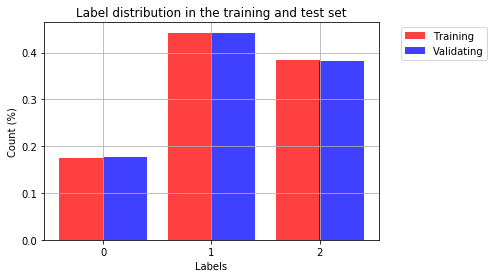

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5956, 2784)
Vectorizer[count], category[task_2], version[1] --> transformed size: 40622
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 2784
Vector Top 20 Head:
         feature  feature_index
2432       zone           2783
2777       zero           2782
1242        yrs           2781
2608        ypg           2780
1270      youth           2779
1907    younger           2778
2071      yikes           2777
1327  yesterday           2776
2219        yes           2775
1897     yellow           2774
215       years           2773
116        year           2772
2171       yeah           2771
2433        yea           2770
964         yds           2769
99        yards           2768
1        yardas           2767
1142       yall           2766
1028      yahoo           2765
2114    xxlarge  

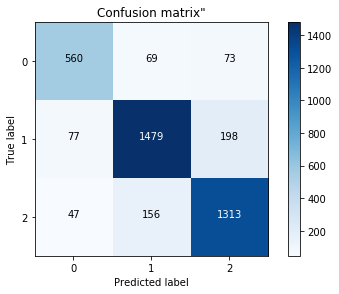

y_test head: [2 0 1 1 0 1 2 1 2 1]
model_pred head: [2 2 1 2 2 1 1 1 2 1]
              precision    recall  f1-score   support

    negative       0.82      0.80      0.81       702
     neutral       0.87      0.84      0.86      1754
    positive       0.83      0.87      0.85      1516

   micro avg       0.84      0.84      0.84      3972
   macro avg       0.84      0.84      0.84      3972
weighted avg       0.84      0.84      0.84      3972



In [33]:
## ----- MNB UNIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_unigram_v{v}'

# perform core training and validation steps
mnb_unigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_unigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_mnb_cnt_vec_bigram_v1


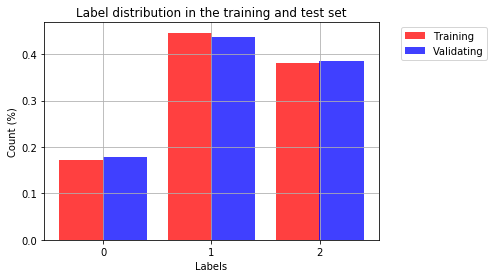

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5956, 6685)
Vectorizer[count], category[task_2], version[1] --> transformed size: 71932
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 6685
Vector Top 20 Head:
                 feature  feature_index
5188     zone coverages           6684
2430               zone           6683
6309                zip           6682
5308  youtube rosterguy           6681
5296            youtube           6680
6105  youth underserved           6679
4572        youth sizes           6678
4568              youth           6677
6457      younger argue           6676
2651            younger           6675
4982                ymd           6674
4496     yesterday knee           6673
4488          yesterday           6672
5996           yes went           6671
5800         yes riding           6670
3286         

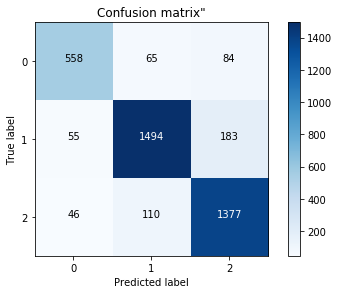

y_test head: [1 1 2 2 0 0 0 2 2 1]
model_pred head: [1 1 2 2 1 0 0 2 2 1]
              precision    recall  f1-score   support

    negative       0.85      0.79      0.82       707
     neutral       0.90      0.86      0.88      1732
    positive       0.84      0.90      0.87      1533

   micro avg       0.86      0.86      0.86      3972
   macro avg       0.86      0.85      0.85      3972
weighted avg       0.86      0.86      0.86      3972



In [34]:
## ----- MNB BIGRAM ------ ##
mnb_clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

model_name = f'task2_mnb_cnt_vec_bigram_v{v}'

# perform core training and validation steps
mnb_bigram_test_pred_results = build_test_validate_models(t2_mnb_count_vec_bigram,
                                                   'mnb',
                                                   mnb_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_unigram_v1


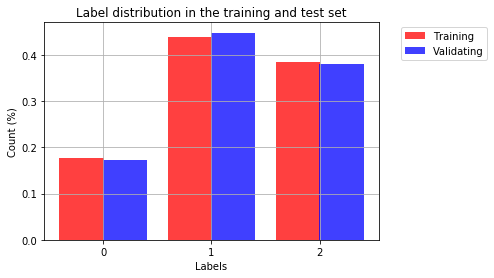

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5956, 2783)
Vectorizer[count], category[task_2], version[1] --> transformed size: 41198
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 2783
Vector Top 20 Head:
         feature  feature_index
2228       zone           2782
285         yrs           2781
1850        ypg           2780
812       youth           2779
181     younger           2778
1048      yikes           2777
2545  yesterday           2776
132         yes           2775
1072     yellow           2774
363       years           2773
2442   yearbook           2772
394        year           2771
1491       yeah           2770
941         yea           2769
1090        yds           2768
126       yards           2767
485        yarb           2766
1924    yankees           2765
221        yall           2764
1165      yahoo  

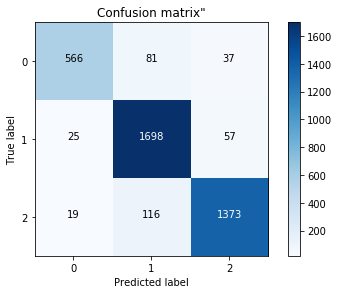

y_test head: [0 1 2 0 0 2 1 0 1 0]
model_pred head: [0 1 2 0 0 2 1 0 1 0]
              precision    recall  f1-score   support

    negative       0.93      0.83      0.87       684
     neutral       0.90      0.95      0.92      1780
    positive       0.94      0.91      0.92      1508

   micro avg       0.92      0.92      0.92      3972
   macro avg       0.92      0.90      0.91      3972
weighted avg       0.92      0.92      0.92      3972



In [35]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task2_svm_cnt_vec_bigram_v1


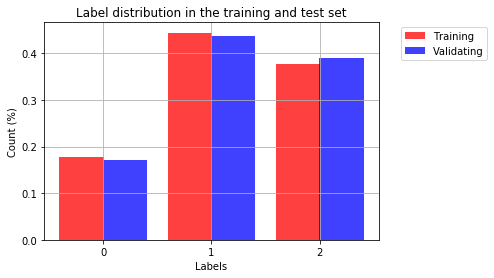

Vectorizer[count], category[task_2], version[1] --> transformed shape: (5956, 6791)
Vectorizer[count], category[task_2], version[1] --> transformed size: 72538
Vectorizer[count], category[task_2], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_2], version[1] --> vocabulary size: 6791
Vector Top 20 Head:
                 feature  feature_index
1480       zone offense           6790
5280     zone coverages           6789
1476               zone           6788
3348                zip           6787
2861               zero           6786
5600                ypg           6785
2169  youtube rosterguy           6784
2155            youtube           6783
2567              youth           6782
3681            younger           6781
1793     yesterday knee           6780
6315     yesterday data           6779
1783          yesterday           6778
5449           yes went           6777
5474           yes prop           6776
2960         

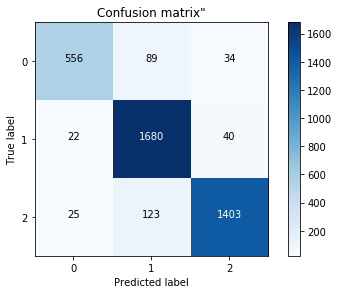

y_test head: [0 2 0 1 1 1 2 1 1 1]
model_pred head: [1 2 0 1 1 1 2 1 1 1]
              precision    recall  f1-score   support

    negative       0.92      0.82      0.87       679
     neutral       0.89      0.96      0.92      1742
    positive       0.95      0.90      0.93      1551

   micro avg       0.92      0.92      0.92      3972
   macro avg       0.92      0.90      0.91      3972
weighted avg       0.92      0.92      0.92      3972



In [36]:
## ----- SVM BIGRAM ------ ##
svm_clf = LinearSVC(C=1)

model_name = f'task2_svm_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t2_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task2,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## TASK 3:
________________________________________________________________________________________________
Now revise the sample script to build your best SVMs model by tuning parameters and using the entire training data set (changing from 60% to 100%). Report what parameters you used to train the model, and its cross validation accuracy.



In [37]:
# Initialize a unigram vector object
t3_svm_count_vec_unigram = br.inst_vectorizer('unigram','count',min_df=2,input='content',stop_words='english',token_pattern=token_pattern)
t3_svm_count_vec_bigram = br.inst_vectorizer('bigram','count',min_df=2,input='content',stop_words='english', token_pattern=token_pattern)

In [38]:
# using gridsearch to tune SVC hyperparameters
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# one hot encoding for dataset labels
lbe = LabelEncoder()
y_train = lbe.fit_transform(y_train)
y_test = lbe.fit_transform(y_test)

train_vec = br.train_vector(logger, t3_svm_count_vec_unigram, X_train, category=None, v_type='count', version=1)
X_train_vec = train_vec[1]

# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'loss': ['hinge','squared_hinge'], 
              }  
  
grid = GridSearchCV(LinearSVC(), param_grid, refit = True, verbose = 3) 

# fitting the model for grid search 
grid.fit(X_train_vec, y_train) 

Vectorizer[count], category[None], version[1] --> transformed shape: (8935, 3494)
Vectorizer[count], category[None], version[1] --> transformed size: 62234
Vectorizer[count], category[None], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[None], version[1] --> vocabulary size: 3494
Vector Top 20 Head:
         feature  feature_index
660        zone           3493
3211        zip           3492
3445        yrs           3491
2285        ypg           3490
2413    youtube           3489
1168      youth           3488
1022    younger           3487
1526       ylem           3486
466       yikes           3485
2271  yesterday           3484
493         yes           3483
1593     yellow           3482
146       years           3481
171        year           3480
2668       yeah           3479
604         yea           3478
795         yds           3477
290       yards           3476
2371     yardas           3475
2873       yarb          

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=0.1, loss=hinge ...............................................
[CV] ....... C=0.1, loss=hinge, score=0.887881839543471, total=   0.0s
[CV] C=0.1, loss=hinge ...............................................
[CV] ....... C=0.1, loss=hinge, score=0.890530557421088, total=   0.1s
[CV] C=0.1, loss=hinge ...............................................
[CV] ...... C=0.1, loss=hinge, score=0.8885157824042982, total=   0.0s
[CV] C=0.1, loss=squared_hinge .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  C=0.1, loss=squared_hinge, score=0.918429003021148, total=   0.0s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.9147078576225655, total=   0.0s
[CV] C=0.1, loss=squared_hinge .......................................
[CV]  C=0.1, loss=squared_hinge, score=0.9150436534586971, total=   0.0s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.9224572004028198, total=   0.3s
[CV] C=1, loss=hinge .................................................
[CV] ........ C=1, loss=hinge, score=0.9288112827400941, total=   0.3s
[CV] C=1, loss=hinge .................................................
[CV] ......... C=1, loss=hinge, score=0.931497649429147, total=   0.6s
[CV] C=1, loss=squared_hinge .........................................
[CV] . C=1, loss=squared_hinge, score=0.918429003021148, total=   0.6s
[CV] C=1, loss=squared_hinge .........................................
[

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1, 10, 100, 1000], 'loss': ['hinge', 'squared_hinge']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [39]:
# print best parameter after tuning 
logger.info(f'grid.best_params_: {grid.best_params_}') 
  
# print how our model looks after hyper-parameter tuning 
logger.info(f'grid.best_estimator_: {grid.best_estimator_}') 

grid.best_params_: {'C': 1, 'loss': 'hinge'}
grid.best_estimator_: LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)


In [40]:
# Input parameter configurations
reportPath_task3 = f'{outputDir}/task3_models_report.txt'
cv=10
train_test_split_ratio=0.2
n_classes=len(np.unique(y))
v=1

Model Name:             task3_svm_cnt_vec_unigram_v1


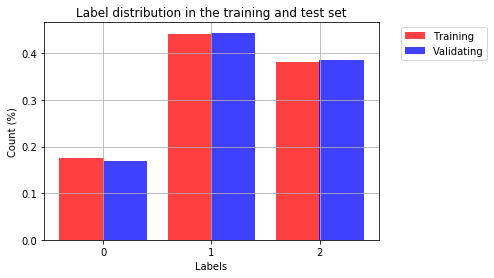

Vectorizer[count], category[task_3], version[1] --> transformed shape: (7942, 3315)
Vectorizer[count], category[task_3], version[1] --> transformed size: 55187
Vectorizer[count], category[task_3], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[1] --> vocabulary size: 3315
Vector Top 20 Head:
         feature  feature_index
1393       zone           3314
3022        zip           3313
3301        yrs           3312
2284        ypg           3311
2797    youtube           3310
1122      youth           3309
1803    younger           3308
2339        ymd           3307
2196       ylem           3306
632   yesterday           3305
872         yes           3304
3165     yellow           3303
81        years           3302
186        year           3301
1767       yeah           3300
415         yea           3299
929         yds           3298
246       yards           3297
2268     yardas           3296
2886       yarb  

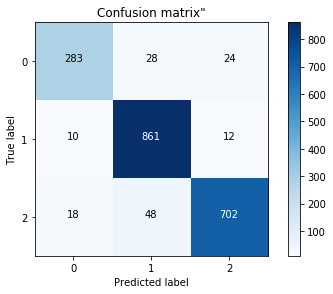

y_test head: [0 0 2 2 2 1 2 1 2 1]
model_pred head: [0 2 2 2 2 1 2 1 2 1]
              precision    recall  f1-score   support

    negative       0.91      0.84      0.88       335
     neutral       0.92      0.98      0.95       883
    positive       0.95      0.91      0.93       768

   micro avg       0.93      0.93      0.93      1986
   macro avg       0.93      0.91      0.92      1986
weighted avg       0.93      0.93      0.93      1986



In [41]:
## ----- SVM UNIGRAM ------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_unigram,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task3_svm_final_cnt_vec_bigram_v1


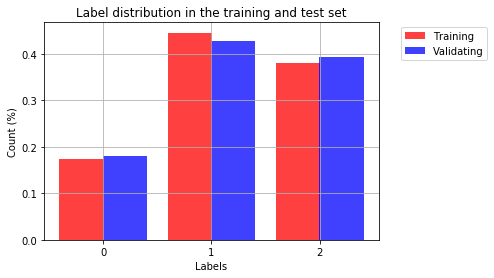

Vectorizer[count], category[task_3], version[1] --> transformed shape: (7942, 8251)
Vectorizer[count], category[task_3], version[1] --> transformed size: 98057
Vectorizer[count], category[task_3], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[1] --> vocabulary size: 8251
Vector Top 20 Head:
                 feature  feature_index
1791          zone read           8250
6542       zone offense           8249
3131     zone coverages           8248
1786               zone           8247
1610                zip           8246
8185               zero           8245
8027                ypg           8244
2030  youtube rosterguy           8243
2017            youtube           8242
7950  youth underserved           8241
162          youth navy           8240
156               youth           8239
7861      younger argue           8238
6120            younger           8237
7425                ymd           8236
3991         

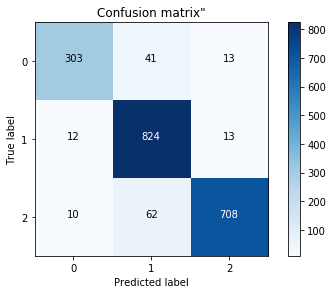

y_test head: [2 1 0 1 2 1 1 1 1 1]
model_pred head: [1 1 0 1 2 1 1 1 1 1]
              precision    recall  f1-score   support

    negative       0.93      0.85      0.89       357
     neutral       0.89      0.97      0.93       849
    positive       0.96      0.91      0.94       780

   micro avg       0.92      0.92      0.92      1986
   macro avg       0.93      0.91      0.92      1986
weighted avg       0.93      0.92      0.92      1986



In [42]:
## ----- SVM BIGRAM ------ ##
svm_clf_final = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_final_cnt_vec_bigram_v{v}'

# perform core training and validation steps
svm_bigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf_final,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task3_svm_final_cnt_vec_unigram_v1


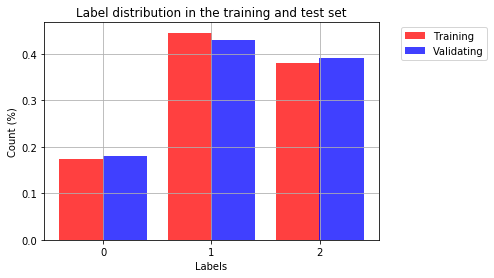

Vectorizer[count], category[task_3], version[1] --> transformed shape: (7942, 8301)
Vectorizer[count], category[task_3], version[1] --> transformed size: 98330
Vectorizer[count], category[task_3], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[count], category[task_3], version[1] --> vocabulary size: 8301
Vector Top 20 Head:
                 feature  feature_index
4460          zone read           8300
2037     zone coverages           8299
2017               zone           8298
7425            yrs old           8297
7420                yrs           8296
6020                ypg           8295
4708  youtube rosterguy           8294
4695            youtube           8293
6270  youth underserved           8292
7954       youth medium           8291
3089              youth           8290
5914      younger argue           8289
4561            younger           8288
5892         ylem texas           8287
5889               ylem           8286
3044         

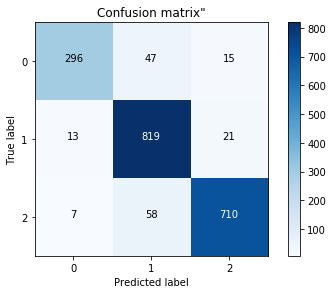

y_test head: [1 1 2 0 2 2 2 1 1 0]
model_pred head: [1 1 2 0 2 2 2 1 1 0]
              precision    recall  f1-score   support

    negative       0.94      0.83      0.88       358
     neutral       0.89      0.96      0.92       853
    positive       0.95      0.92      0.93       775

   micro avg       0.92      0.92      0.92      1986
   macro avg       0.92      0.90      0.91      1986
weighted avg       0.92      0.92      0.92      1986



In [43]:
## ----- SVM Unigram ------ ##
svm_clf_final = LinearSVC(C=1,loss='hinge')

model_name = f'task3_svm_final_cnt_vec_unigram_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t3_svm_count_vec_bigram,
                                                   'svm',
                                                   svm_clf_final,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task3,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

## Task 4 - Create Models from best scorrers in HW6

In [44]:
# Initialize a unigram vector object
t4_svm_tfidf_vec_unigram_bool = br.inst_vectorizer('unigram','tfidf',min_df=2,input='content',stop_words='english', binary=True, token_pattern=token_pattern)
t4_svm_tfidf_vec_bigram_bool = br.inst_vectorizer('bigram','tfidf',min_df=2,input='content',stop_words='english', binary=True, token_pattern=token_pattern)

In [45]:
# Input parameter configurations
reportPath_task4 = f'{outputDir}/task4_models_report.txt'
cv=10
train_test_split_ratio=0.4
n_classes=len(np.unique(y))
v=1

Model Name:             task4_svm_tfidf_vec_unigram_bool_v1


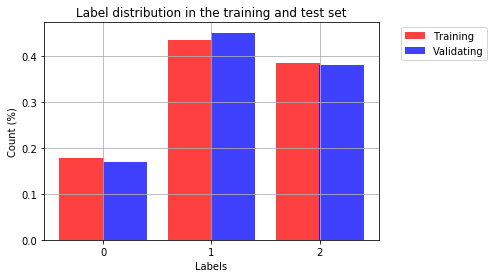

Vectorizer[tfidf], category[task_4], version[1] --> transformed shape: (5956, 2843)
Vectorizer[tfidf], category[task_4], version[1] --> transformed size: 40940
Vectorizer[tfidf], category[task_4], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[1] --> vocabulary size: 2843
Vector Top 20 Head:
         feature  feature_index
271        zone           2842
1097        yrs           2841
169       youth           2840
1889    younger           2839
2679        ymd           2838
2669       ylem           2837
1868  yesterday           2836
1371        yes           2835
2141     yellow           2834
21        years           2833
131        year           2832
1044       yeah           2831
1424        yea           2830
698         yds           2829
464       yards           2828
1491     yardas           2827
2752       yarb           2826
2150    yankees           2825
1257       yall           2824
1742       yale  

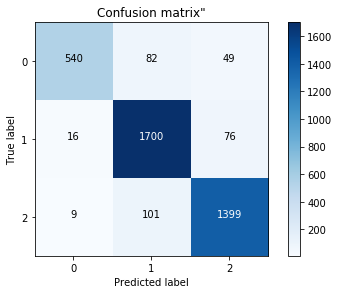

y_test head: [1 0 1 1 2 0 1 1 1 2]
model_pred head: [1 0 1 1 2 0 1 1 1 1]
              precision    recall  f1-score   support

    negative       0.96      0.80      0.87       671
     neutral       0.90      0.95      0.93      1792
    positive       0.92      0.93      0.92      1509

   micro avg       0.92      0.92      0.92      3972
   macro avg       0.93      0.89      0.91      3972
weighted avg       0.92      0.92      0.92      3972



In [46]:
## ----- SVM UNIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_unigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_unigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

Model Name:             task4_svm_tfidf_vec_bigram_bool_v1


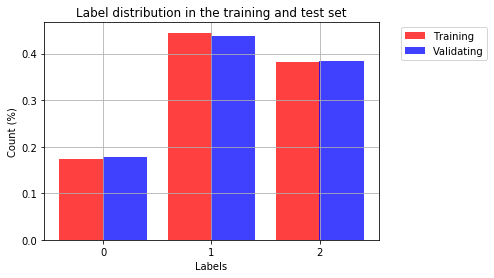

Vectorizer[tfidf], category[task_4], version[1] --> transformed shape: (5956, 6809)
Vectorizer[tfidf], category[task_4], version[1] --> transformed size: 72122
Vectorizer[tfidf], category[task_4], version[1] --> transformed type: <class 'scipy.sparse.csr.csr_matrix'>
Vectorizer[tfidf], category[task_4], version[1] --> vocabulary size: 6809
Vector Top 20 Head:
                 feature  feature_index
410           zone read           6808
5082       zone offense           6807
403                zone           6806
4606                zip           6805
3340  youtube rosterguy           6804
3327            youtube           6803
6451  youth underserved           6802
4958        youth sizes           6801
1479              youth           6800
5092            younger           6799
3703               ylem           6798
6579     yesterday knee           6797
4228          yesterday           6796
1829           yes went           6795
2938           yes prop           6794
6607         

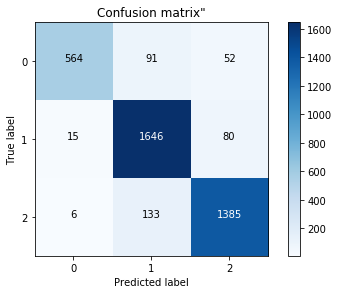

y_test head: [0 1 1 0 1 1 2 1 1 0]
model_pred head: [0 1 1 2 1 1 2 1 1 0]
              precision    recall  f1-score   support

    negative       0.96      0.80      0.87       707
     neutral       0.88      0.95      0.91      1741
    positive       0.91      0.91      0.91      1524

   micro avg       0.91      0.91      0.91      3972
   macro avg       0.92      0.88      0.90      3972
weighted avg       0.91      0.91      0.90      3972



In [47]:
## ----- SVM BIGRAM BOOL------ ##
svm_clf = LinearSVC(C=1,loss='hinge')

model_name = f'task4_svm_tfidf_vec_bigram_bool_v{v}'

# perform core training and validation steps
svm_unigram_test_pred_results = build_test_validate_models(t4_svm_tfidf_vec_bigram_bool,
                                                   'svm',
                                                   svm_clf,
                                                   model_name,
                                                   X,
                                                   y,
                                                   reportPath_task4,
                                                   outputDir,
                                                   cv=cv,
                                                   test_size=train_test_split_ratio,
                                                   n_classes=n_classes)

### Evaluate Model Results

In [48]:
# build summary report df
summary_report_df = pd.DataFrame()

summary_report_df['Model_Type'] = model_types
summary_report_df['Category'] = categories
summary_report_df['Vectorizer'] = vectorizers
summary_report_df['N_Gram'] = ngrams
summary_report_df['Experiment_Model_Name'] = exp_model_names
summary_report_df['Dataset_Version'] = dataset_versions
summary_report_df['Cross_Folds'] = cross_folds
summary_report_df['Prediction_Accuracy'] = prediction_accuracys
summary_report_df['Total_Prediction_Points'] = total_prediction_points
summary_report_df['Test_Recall_Score_Avg'] = test_recall_score_avgs
summary_report_df['Test_Precision_Score_Avg'] = test_precision_score_avgs
summary_report_df['Train_Recall_Score_Avg'] = train_recall_score_avgs
summary_report_df['Train_Precision_Score_Avg'] = train_precision_score_avgs
summary_report_df['Total_Build_Time'] = total_build_times
summary_report_df['Total_Predict_Time'] = total_predict_time
summary_report_df['Confusion_Matrix'] = confusion_matrixs

summary_report_df.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,85.60,3972,0.8411,0.8459,0.8991,0.9034,0.0809,0.0021,[[ 550 65 76]\n [ 57 1509 189]\n [ 43 ...
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,92.04,3972,0.9049,0.9202,0.9922,0.9955,2.9593,0.0012,[[ 557 79 31]\n [ 21 1699 62]\n [ 22 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,84.39,3972,0.8444,0.8421,0.9007,0.9029,0.0878,0.0008,[[ 560 69 73]\n [ 77 1479 198]\n [ 47 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,86.33,3972,0.8534,0.8570,0.9130,0.9196,0.0901,0.0023,[[ 558 65 84]\n [ 55 1494 183]\n [ 46 ...
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,91.57,3972,0.9068,0.9274,0.9919,0.9955,3.3760,0.0005,[[ 566 81 37]\n [ 25 1698 57]\n [ 19 ...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,91.62,3972,0.9015,0.9230,0.9944,0.9971,5.4663,0.0022,[[ 556 89 34]\n [ 22 1680 40]\n [ 25 ...
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.95,1986,0.9200,0.9388,0.9850,0.9907,4.4468,0.0006,[[283 28 24]\n [ 10 861 12]\n [ 18 48 702]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,92.40,1986,0.9079,0.9301,0.9879,0.9932,4.2892,0.0015,[[303 41 13]\n [ 12 824 13]\n [ 10 62 708]]
8,LinearSVM,task_3,count,unigram,task3_svm_final_cnt_vec_unigram_v1,v1,10,91.89,1986,0.9117,0.9343,0.9899,0.9944,3.8344,0.0012,[[296 47 15]\n [ 13 819 21]\n [ 7 58 710]]
9,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,91.62,3972,0.8904,0.9200,0.9592,0.9744,3.9726,0.0014,[[ 540 82 49]\n [ 16 1700 76]\n [ 9 ...


In [49]:
sorted_summary_report = summary_report_df.sort_values(by=['Prediction_Accuracy','Experiment_Model_Name'], ascending=False)
sorted_summary_report

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.95,1986,0.9200,0.9388,0.9850,0.9907,4.4468,0.0006,[[283 28 24]\n [ 10 861 12]\n [ 18 48 702]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,92.40,1986,0.9079,0.9301,0.9879,0.9932,4.2892,0.0015,[[303 41 13]\n [ 12 824 13]\n [ 10 62 708]]
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,92.04,3972,0.9049,0.9202,0.9922,0.9955,2.9593,0.0012,[[ 557 79 31]\n [ 21 1699 62]\n [ 22 ...
8,LinearSVM,task_3,count,unigram,task3_svm_final_cnt_vec_unigram_v1,v1,10,91.89,1986,0.9117,0.9343,0.9899,0.9944,3.8344,0.0012,[[296 47 15]\n [ 13 819 21]\n [ 7 58 710]]
9,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,91.62,3972,0.8904,0.9200,0.9592,0.9744,3.9726,0.0014,[[ 540 82 49]\n [ 16 1700 76]\n [ 9 ...
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,91.62,3972,0.9015,0.9230,0.9944,0.9971,5.4663,0.0022,[[ 556 89 34]\n [ 22 1680 40]\n [ 25 ...
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,91.57,3972,0.9068,0.9274,0.9919,0.9955,3.3760,0.0005,[[ 566 81 37]\n [ 25 1698 57]\n [ 19 ...
10,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,90.51,3972,0.8892,0.9197,0.9643,0.9783,4.6496,0.0010,[[ 564 91 52]\n [ 15 1646 80]\n [ 6 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,86.33,3972,0.8534,0.8570,0.9130,0.9196,0.0901,0.0023,[[ 558 65 84]\n [ 55 1494 183]\n [ 46 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,85.60,3972,0.8411,0.8459,0.8991,0.9034,0.0809,0.0021,[[ 550 65 76]\n [ 57 1509 189]\n [ 43 ...


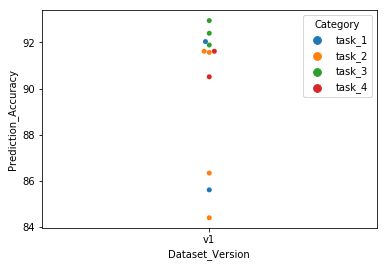

In [50]:
sns.swarmplot(x='Dataset_Version',y='Prediction_Accuracy',hue='Category',data=summary_report_df)

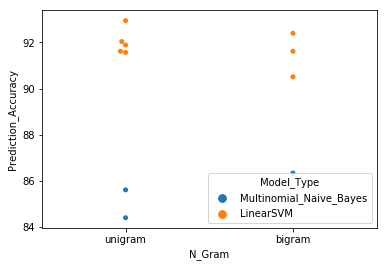

In [51]:
sns.swarmplot(x='N_Gram',y='Prediction_Accuracy',hue='Model_Type',data=summary_report_df)

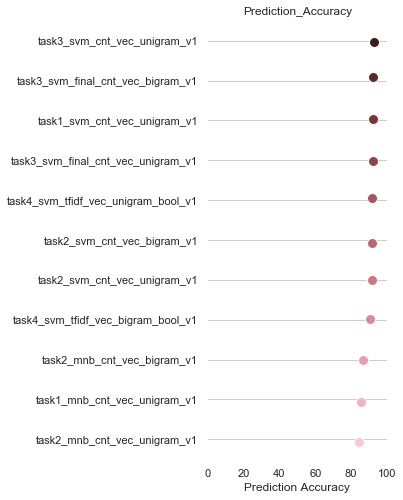

In [52]:
sns.set(style="whitegrid")
g = sns.PairGrid(sorted_summary_report,x_vars='Prediction_Accuracy', 
                 y_vars=['Experiment_Model_Name'], height=7, aspect=.50)

#Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=10, orient="h",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(0, 100), xlabel="Prediction Accuracy", ylabel="")


# Use semantically meaningful titles for the columns
titles = ["Prediction_Accuracy"]

for ax, title in zip(g.axes.flat, titles):

    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)

In [53]:
sorted_summary_report_v1 = summary_report_df.sort_values(by=['Dataset_Version','Prediction_Accuracy'], ascending=False)
sorted_summary_report_v1.head(10)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
6,LinearSVM,task_3,count,unigram,task3_svm_cnt_vec_unigram_v1,v1,10,92.95,1986,0.9200,0.9388,0.9850,0.9907,4.4468,0.0006,[[283 28 24]\n [ 10 861 12]\n [ 18 48 702]]
7,LinearSVM,task_3,count,bigram,task3_svm_final_cnt_vec_bigram_v1,v1,10,92.40,1986,0.9079,0.9301,0.9879,0.9932,4.2892,0.0015,[[303 41 13]\n [ 12 824 13]\n [ 10 62 708]]
1,LinearSVM,task_1,count,unigram,task1_svm_cnt_vec_unigram_v1,v1,10,92.04,3972,0.9049,0.9202,0.9922,0.9955,2.9593,0.0012,[[ 557 79 31]\n [ 21 1699 62]\n [ 22 ...
8,LinearSVM,task_3,count,unigram,task3_svm_final_cnt_vec_unigram_v1,v1,10,91.89,1986,0.9117,0.9343,0.9899,0.9944,3.8344,0.0012,[[296 47 15]\n [ 13 819 21]\n [ 7 58 710]]
5,LinearSVM,task_2,count,bigram,task2_svm_cnt_vec_bigram_v1,v1,10,91.62,3972,0.9015,0.9230,0.9944,0.9971,5.4663,0.0022,[[ 556 89 34]\n [ 22 1680 40]\n [ 25 ...
9,LinearSVM,task_4,tfidf,unigram,task4_svm_tfidf_vec_unigram_bool_v1,v1,10,91.62,3972,0.8904,0.9200,0.9592,0.9744,3.9726,0.0014,[[ 540 82 49]\n [ 16 1700 76]\n [ 9 ...
4,LinearSVM,task_2,count,unigram,task2_svm_cnt_vec_unigram_v1,v1,10,91.57,3972,0.9068,0.9274,0.9919,0.9955,3.3760,0.0005,[[ 566 81 37]\n [ 25 1698 57]\n [ 19 ...
10,LinearSVM,task_4,tfidf,bigram,task4_svm_tfidf_vec_bigram_bool_v1,v1,10,90.51,3972,0.8892,0.9197,0.9643,0.9783,4.6496,0.0010,[[ 564 91 52]\n [ 15 1646 80]\n [ 6 ...
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,86.33,3972,0.8534,0.8570,0.9130,0.9196,0.0901,0.0023,[[ 558 65 84]\n [ 55 1494 183]\n [ 46 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,85.60,3972,0.8411,0.8459,0.8991,0.9034,0.0809,0.0021,[[ 550 65 76]\n [ 57 1509 189]\n [ 43 ...


In [54]:
# avg prediciton by data version
v4_avg = summary_report_df[summary_report_df['Dataset_Version']=='v4'].Prediction_Accuracy.mean()
logger.info(f'V4 Avg Prediciton Accuracy: {v4_avg}')
v3_avg = summary_report_df[summary_report_df['Dataset_Version']=='v3'].Prediction_Accuracy.mean()
logger.info(f'V3 Avg Prediciton Accuracy: {v3_avg}')
v2_avg = summary_report_df[summary_report_df['Dataset_Version']=='v2'].Prediction_Accuracy.mean()
logger.info(f'V2 Avg Prediciton Accuracy: {v2_avg}')
v1_avg = summary_report_df[summary_report_df['Dataset_Version']=='v1'].Prediction_Accuracy.mean()
logger.info(f'V1 Avg Prediciton Accuracy: {v1_avg}')

# avg prediction by n_gram
unigram_avg = summary_report_df[summary_report_df['N_Gram']=='unigram'].Prediction_Accuracy.mean()
logger.info(f'unigram_avg Prediciton Accuracy: {unigram_avg}')
bigram_avg = summary_report_df[summary_report_df['N_Gram']=='bigram'].Prediction_Accuracy.mean()
logger.info(f'bigram_avg Prediciton Accuracy: {bigram_avg}')



V4 Avg Prediciton Accuracy: nan
V3 Avg Prediciton Accuracy: nan
V2 Avg Prediciton Accuracy: nan
V1 Avg Prediciton Accuracy: 90.08363636363636
unigram_avg Prediciton Accuracy: 90.00857142857141
bigram_avg Prediciton Accuracy: 90.215


In [55]:
mnb_df = summary_report_df[summary_report_df['Model_Type']=='Multinomial_Naive_Bayes']
mnb_df.sort_values(by='Prediction_Accuracy', ascending=False).head(5)

,Model_Type,Category,Vectorizer,N_Gram,Experiment_Model_Name,Dataset_Version,Cross_Folds,Prediction_Accuracy,Total_Prediction_Points,Test_Recall_Score_Avg,Test_Precision_Score_Avg,Train_Recall_Score_Avg,Train_Precision_Score_Avg,Total_Build_Time,Total_Predict_Time,Confusion_Matrix
3,Multinomial_Naive_Bayes,task_2,count,bigram,task2_mnb_cnt_vec_bigram_v1,v1,10,86.33,3972,0.8534,0.8570,0.9130,0.9196,0.0901,0.0023,[[ 558 65 84]\n [ 55 1494 183]\n [ 46 ...
0,Multinomial_Naive_Bayes,task_1,count,unigram,task1_mnb_cnt_vec_unigram_v1,v1,10,85.60,3972,0.8411,0.8459,0.8991,0.9034,0.0809,0.0021,[[ 550 65 76]\n [ 57 1509 189]\n [ 43 ...
2,Multinomial_Naive_Bayes,task_2,count,unigram,task2_mnb_cnt_vec_unigram_v1,v1,10,84.39,3972,0.8444,0.8421,0.9007,0.9029,0.0878,0.0008,[[ 560 69 73]\n [ 77 1479 198]\n [ 47 ...


In [56]:
# save summary report
save_as = f'{outputDir}/summary_report.csv'
summary_report_df.to_csv(save_as,index=False)

## Model Timeseries On NFL Only Data
Perform model prediction

# Report Generation
Execute the below cell to create an HTML report

In [57]:
# for report auto generation
# testing markup report generation
#from nbconvert import HTMLExporter
#import codecs
#import os
#import datetime

#stamp = datetime.date.today().strftime("%m-%d-%Y")
#exporter = HTMLExporter(template_file='report.tpl')
#output, resources = exporter.from_filename(notebook_file_name)
#new_fnw = report_file_name
#codecs.open(new_fnw, 'w',encoding='utf-8').write(output)